In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc

import gym
from mountaincar import MountainCarEnv

In [2]:
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

## Explore The Environment

In [3]:
env = MountainCarEnv(); env.seed(90);

In [4]:
print('Environment Display:')
state = env.reset() # reset environment to a new, random state
score = 0

for time_step in range(200):
    
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break

print('State space', env.observation_space)
print('Action space', env.action_space)
print('Final score:', score)
env.close()

Environment Display:
State space Box(2,)
Action space Discrete(3)
Final score: -200.0


In [5]:
# explore state (observation) space
print('State space:', env.observation_space)
print(f'- Position: {env.observation_space.low[0]} - {env.observation_space.high[0]}')
print(f'- Velocity: {env.observation_space.low[1]} - {env.observation_space.high[1]}')

State space: Box(2,)
- Position: -1.2000000476837158 - 0.6000000238418579
- Velocity: -0.07000000029802322 - 0.07000000029802322


In [6]:
# Explore the action space
print("Action space:", env.action_space)
print('0 Push left')
print('1 No push')
print('2 Push right')

Action space: Discrete(3)
0 Push left
1 No push
2 Push right


## Discretize the State Space with a Uniform Grid

In [7]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space."""
    
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    return grid

In [8]:
def discretize(sample, grid):
    """Discretize a sample as per given grid."""
    return list(int(np.digitize(s, g)) for s, g in zip(sample, grid))

In [9]:
low = [-1.0, -5.0]
high = [1.0, 5.0]

In [10]:
grid = create_uniform_grid(low, high, bins=(10, 10))
samples = np.array([[-0.8 , -4.8], [-0.81, -4.1], [-0.8 , -4.0], [-0.5 ,  0.0], 
                    [ 0.2 , -1.9], [ 0.8 ,  4.0], [ 0.81,  4.1], [ 0.73 ,  4.32]])

discretized_samples = np.array([discretize(sample, grid) for sample in samples])

## Visualize The Discritization

In [11]:
def visualize_samples(samples, discretized_samples, grid, low=None, high=None, env=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # if bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # otherwise use first, list grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]
        
    # map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples
    
    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])
    
    if env == 'mountaincar':
        # axis labels for MountainCar-v0 state space
        plt.xlabel('position'); plt.ylabel('velocity');
    else:
        plt.xlabel('x-axis (state 1)'); plt.ylabel('y-axis (state 2)');
    
    plt.show()

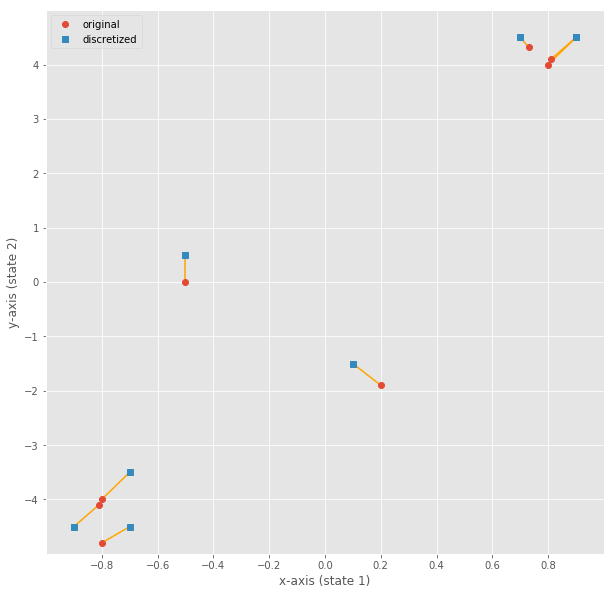

In [12]:
visualize_samples(samples, discretized_samples, grid, low, high)

## Apply The Uniform Grid

In [13]:
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))

In [14]:
# obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for _ in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])

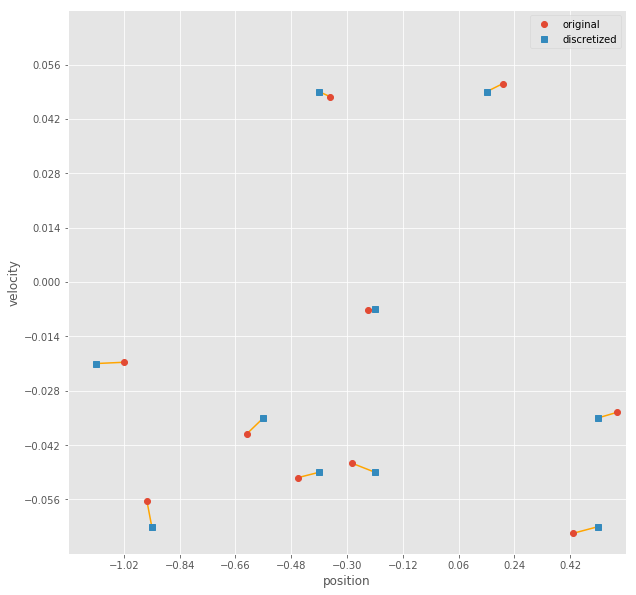

In [15]:
visualize_samples(state_samples, discretized_state_samples, state_grid, 
                  env.observation_space.low, env.observation_space.high, env='mountaincar')

## Apply Q-Learning

In [16]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""
    
    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99, 
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""        
        pass
    
    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        pass
    
    def reset_episode(self, state):
        """Reset variables for a new episode."""
        pass
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        pass
    
    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        pass

In [17]:
q_agent = QLearningAgent(env, state_grid)

---